In [1]:
# /ch4/ch4_5_att/att.ipynb
# 标准库
import sys

# 第三方库
import numpy as np
import tqdm
import torch

# 自定义模块
sys.path.append('./../../')
import utils.dataset as d
import utils.metrics as m
import utils.plot as p
from dataset import TimeDataset
from model import MultiheadsSelfAttention

# 绘图参数
name_model = 'ATT'
name_var = '温度'
name_unit = ' ($^{\circ}C$)'
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


In [2]:
# 参数设置
learning_rate = 0.001
num_epoch = 200
batch_size = 4


num_data=365
len(trainData)=255, len(testData)=110


,序列长度,最大值,最小值,均值,标准差,偏度,峰度
0,8784,32.77,-2.53,11.7,5.72,0.4,-0.16


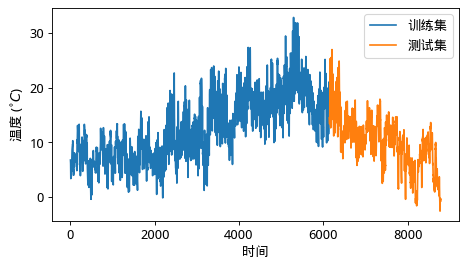

In [3]:
# 数据读取
data = TimeDataset(
    path_data='./data/data_temp.csv',
    data_type='AirTemp',
    size_window=24,
    size_input=1,
    size_output=1  # size_output需与size_input相等
)
num_data = len(data)
print(f'{num_data=}')

# 训练测试划分
ratio_train = 0.7  # 训练样本比例
num_train = int(num_data*ratio_train)  # 训练样本数量
trainData = torch.utils.data.Subset(data, range(num_train))
testData = torch.utils.data.Subset(data, range(num_train, num_data))
print(f'{len(trainData)=}, {len(testData)=}')

# 数据集加载器
trainLoader = torch.utils.data.DataLoader(
    trainData,
    batch_size=batch_size,
    shuffle=True
)
testLoader = torch.utils.data.DataLoader(
    testData,
    batch_size=batch_size,
    shuffle=False
)

# 数据集分析和可视化
d.stats(data.data)
p.plot_dataset(
    train=data.data[:(len(trainData)+1)*24],
    test=data.data[(len(trainData)+1)*24:],
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_序列'
)

In [4]:
# 训练设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型构建
model = MultiheadsSelfAttention(
    dim_input=24, 
    num_neurons=48, 
    dim_output=24, 
    num_heads=8
).to(DEVICE)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 损失函数
loss_func = torch.nn.MSELoss()

# 模型查看
print(model)

# 训练集-训练
loss_train = []
loss_test = []
bar = tqdm.trange(num_epoch, ncols=100)
for epoch in bar:

    # 初始化
    bar.set_description(f'Epoch: {epoch+1}')
    loss_epoch = []
    model.train()

    # 迭代全部训练样本
    for i, data in enumerate(trainLoader):

        # 获取数据
        targets = data[1].to(DEVICE).float()
        inputs = data[0].to(DEVICE).float()

        # 前向传播
        outputs = model(inputs)

        # 损失计算
        loss = loss_func(outputs, targets).to(DEVICE)

        # 误差反向传播
        loss.backward()

        # 更新模型参数
        optimizer.step()
        optimizer.zero_grad()

        # 当前批次损失
        loss_epoch.append(loss.item())

    # 训练损失
    loss_train.append(sum(loss_epoch)/(i+1))

    # 验证/测试
    model.eval()
    loss_epoch = []
    for i, data in enumerate(testLoader):

        # 获取数据
        targets = data[1].to(DEVICE).float()
        inputs = data[0].to(DEVICE).float()

        # 前向传播
        outputs = model(inputs)

        # 损失计算
        loss = loss_func(outputs, targets).to(DEVICE)

        # 当前批次损失
        loss_epoch.append(loss.item())

    # 测试损失
    loss_test.append(sum(loss_epoch)/(i+1))

    # 更新进度显示
    bar.set_postfix(
        loss=f'{loss_train[-1]:.6f}',
        loss_test=f'{loss_test[-1]:.6f}'
    )


MultiheadsSelfAttention(
  (query): Linear(in_features=24, out_features=48, bias=True)
  (key): Linear(in_features=24, out_features=48, bias=True)
  (value): Linear(in_features=24, out_features=48, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
  )
  (linear): Linear(in_features=48, out_features=24, bias=True)
)


Epoch: 200: 100%|██████████████| 200/200 [00:32<00:00,  6.21it/s, loss=4.808405, loss_test=4.605866]


In [5]:
# 测试集-预测
y_true = []
y_pred = []
model.eval()
with torch.no_grad():

    # 迭代全部测试样本
    for i, data in enumerate(testLoader):

        # 获取数据
        targets = data[1].to(DEVICE).float()
        inputs = data[0].to(DEVICE).float()

        # 前向传播
        outputs = model(inputs)

        # 存储测试集真值和预测值
        y_true.append(targets.detach().cpu().numpy().squeeze().reshape(1, -1))
        y_pred.append(outputs.detach().cpu().numpy().squeeze().reshape(1, -1))

# 重构输出
y_true = np.hstack(y_true).squeeze()
y_pred = np.hstack(y_pred).squeeze()

# 测试集-误差计算
m.all_metrics(y_true, y_pred)


mse=4.577
rmse=2.139
mae=1.591
mape=41.962%
sde=2.116
r2=0.790
pcc=0.892


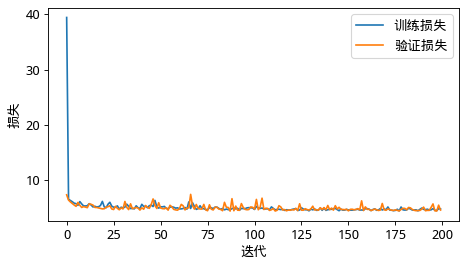

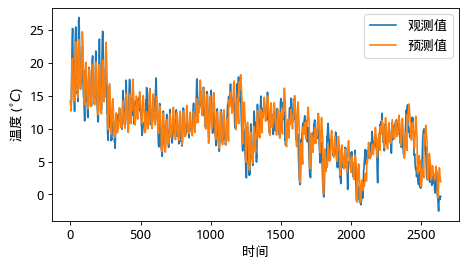

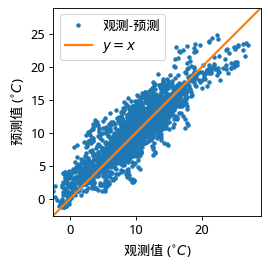

In [6]:
# 可视化
p.plot_losses(
    train_loss=loss_train,
    val_loss=loss_test,
    xlabel='迭代',
    ylabel='损失',
    fig_name=f'{name_model}_损失'
)
p.plot_results(
    y_true=y_true,
    y_pred=y_pred,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_预测曲线'
)
p.plot_parity(
    y_true=y_true,
    y_pred=y_pred,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)
